# MagNet: Model the Geomagnetic Field Chapter 2
## Explainable AI (XAI)

![HELIO_GRAPHIC_URL](https://ngdc.noaa.gov/geomag/img/challenge-banner.png "HELIO")

* Creator(s): Rob.Redmon@noaa.gov (1,2), Manoj.C.Nair@noaa.gov (2,3), LiYin.Young@noaa.gov (2,3)
* Affiliation(s):
    * 1. National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/)), National Oceanic and Atmospheric Administration (NOAA),
    * 2. NOAA Center for Artificial Intelligence ([NCAI](https://noaa.gov/ai)),
    * 3. Cooperative Institute for Research for Environmental Sciences [CIRES](https://cires.colorado.edu/).
* History
    * 2023-08: Content reorganized for the [NCAI](https://noaa.gov/ai) <i>Learning Journey</i> library. No significant technical changes from previous version.
    * 2022-06: Initial notebook version developed for the [TAI4ES 2022 Summer School](https://www2.cisl.ucar.edu/events/tai4es-2022-summer-school).
* Acknowledgements:
    * Original funding support was provided by the NCEI Innovates program.
    * Post-model inference and evaluation were created for the NCAR and [AI2ES](https://www.ai2es.org/) [TAI4ES 2022 Summer School](https://www2.cisl.ucar.edu/events/tai4es-2022-summer-school).

---

## Overview
<b>Chapter 2 "Explainable AI (XAI)"</b>, of the two notebook series, focuses on evaluating the benchmark model developed in <b>Chapter 1 "Develop the LSTM Model"</b> for predicting the disturbance-storm-time (<i>Dst</i>) index space weather storm indicator.

### Prerequisites

* <b>Chapter 1:</b> The first chapter builds the model with benchmark or user defined hyper parameter settings.
* <b>Python intermediate proficiency for data science:</b> SciPy, Pandas, NumPy, MatplotLib,
* <b>Machine Learning intermediate experience:</b> ML for supervised modeling of time series data using neural networks. We use the Keras framework for TensorFlow in this notebook to create a Long Short-Term Memory (LSTM) recurrent neural network,
* <b>Space Weather introductory knowledge:</b> Basic familiarity of the Solar Wind and the Disturbance Storm Time activity index (<i>Dst</i>). For introductory materials on space weather and its effects on the technological systems we rely on, two resources are:
    * [NASA's Space Place](https://spaceplace.nasa.gov/spaceweather/),
    * [NOAA's Space Weather Prediction Center (SWPC)](https://www.swpc.noaa.gov/), in particular their community dashboards.

### Targeted Level
This notebook is targeted towards learners with beginner to intermediate experience in space weather topics, and intermediate experience in modeling time series data with neural networks.

### Learning Outcomes

By engaging in this notebook series, the learner will get introductory experience with Explainable AI (XAI) topics through:
1. Evaluating input (feature) relative importance to model performance via the "permutation importance" technique,
2. Evaluating the trained model on classical space weather events.

<div class="alert alert-block alert-info">
<b>Info: </b>
In this notebook, you'll notice color-coded boxes, which provide hints, exercises, and warnings. Here is the color-coding breakdown:
</div>

* <span style="color:blue">Hint/Tip/Info: </span> Helpful context and guidance, as a blue alert-info box
* <span style="color:green">Exercise: </span> Interactive activity / exercise, as a green alert-success box
* <span style="color:orange">Be Aware: </span> Caution / Caveat, as a yellow alert-warn box
* <span style="color:red">Danger: </span> Conditions under which code may create an error, as a red alert-danger box

---

## Tutorial Material

<div class="alert alert-block alert-info">
<b>Info: </b>See <b>Chapter</b> 1 in the MagNet LSTM series.
</div>

### Software
This notebook has been tested using the following environments:
* Google Colaboratory (Python 3.10.12) with no need to install additional packages.
    * CPU, GPU, TPU tested
* Anaconda (Python 3.9.16) with the following key package versions:
    * Keras TensorFlow 2.8.0
    * Pandas 1.5.3
    * Matplotlib 3.7.1
    * CPU, and GPU tested

---

### Acquire Data

<div class="alert alert-block alert-info">
<b>Info: </b>
The competition discussed above used <i>public</i> data for development and the public leaderboard. A <i>private</i> dataset was kept internal during the competition for use in scoring by the organizers. Since the competition has passed, both datasets are publicly accessible from NOAA. We will build and evaluate the model using the competition's <i>public</i> data and evaluate storm event case studies using the competition's <i>private</i> data.
</div>

In [1]:
# Download data we need: If directory "data/" already exists, we'll assume the data are already downloaded.
# The files are 381 MB zipped and 1.2 GB unzipped
# Retrieving these files from NOAA takes 30-60 seconds on a home internet connection.

import os, urllib, zipfile

dir_data = 'data/'
if not os.path.isdir(dir_data):
    os.mkdir(dir_data)

    # Zenodo URLs
    urls = ['https://zenodo.org/record/8197443/files/public.zip?download=1',
            'https://zenodo.org/record/8197443/files/private.zip?download=1']
    
    # NOAA URLs (same exact data as on Zenodo) -- uncomment to download from NOAA
    #     urls = ['https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip',
    #             'https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip']

    # Download and unzip each file
    for url in urls:
        zip_path, _ = urllib.request.urlretrieve(url)
        with zipfile.ZipFile(zip_path, "r") as f:
            print('Downloaded ', url, ', now unzipping.')
            f.extractall(dir_data)

# Print list of data files:
print('\nData files for input (features) and output Dst (labels):')
for dir_pubpriv in ['public/', 'private/']:
    print(dir_data+dir_pubpriv)
    for path, dirs, files in os.walk(dir_data+dir_pubpriv): 
        for f in files: print('\t', f)

Downloaded  https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip , now unzipping.
Downloaded  https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip , now unzipping.

Data files for input (features) and output Dst (labels):
data/public/
	 satellite_positions.csv
	 dst_labels.csv
	 solar_wind.csv
	 sunspots.csv
data/private/
	 satellite_positions.csv
	 dst_labels.csv
	 solar_wind.csv
	 sunspots.csv


In [2]:
# Modules we need to get started and Matplotlib configuration:
import numpy as np, pandas as pd, pprint
import matplotlib.pyplot as plt

# The next two lines are nice for Jupyter, but not available for Colab:
#%load_ext nb_black
#%matplotlib inline

# Matplotlib Configuration
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

#### Import  Input (Features) and Output (Labels) as Pandas DataFrames
<div class="alert alert-block alert-info">
<b>Info:</b> As described above, the input data is a time series of solar wind measurements at L1 along with sunspot number, and the output data is a time series of <i>Dst</i>. Recall that for the past competition, the competitors did not have the real geophysical date/time. So here, we will recreate a new column of real geophysical date/time from our timedelta and the table shown in "Data Summary".
</div>

In [3]:
# From our time range table in the "Data Summary" section:
period_ranges = {
    'train_a':[pd.Timestamp('1998/2/16 00:00:00'), pd.Timestamp('2001/5/31  23:59:00')],
    'train_b':[pd.Timestamp('2013/6/1  00:00:00'), pd.Timestamp('2019/5/31  23:59:00')],
    'train_c':[pd.Timestamp('2004/5/1  00:00:00'), pd.Timestamp('2010/12/31 23:59:00')],
    'test_a' :[pd.Timestamp('2001/6/1  00:00:00'), pd.Timestamp('2004/4/30  23:59:00')],
    'test_b' :[pd.Timestamp('2011/1/1  00:00:00'), pd.Timestamp('2013/5/31  23:59:00')],
    'test_c' :[pd.Timestamp('2019/6/1  00:00:00'), pd.Timestamp('2020/10/31 23:59:00')]}

def convert_timedelta_to_datetime( df ):
    """Adds real geophysical datetimes to our DataFrame using the original "index" timestamps.
    
    The relative "index" timestamps were used in the MagNet competition datasets since all of the data
    were in the public domain.
    
    Parameters
    ----------
    df: pd.DataFrame
        Includes index time
    
    Returns
    -------
    df_datetimes: pd.DataFrame
        Adds datetimes to the input pd.DataFrame
    """
    df_datetimes = pd.DataFrame(index=df.index)
    df_datetimes['datetime'] = pd.NaT     # like Numpy NaN

    i = 0
    for period_name, timedelta in df.index:
        start_time = period_ranges[period_name][0]
        datetime = timedelta + start_time                 # add Pandas Timedelta to Pandas Timestamp
        df_datetimes['datetime'].values[i] = datetime
        i += 1

        #print('%s: %s + %s = %s' % (period_name, timedelta, start_time, df['datetime'].values[i]))

    return df_datetimes

In [4]:
# Import as Pandas DataFrames
from pathlib import Path
DATA_PATH = Path("data/public/")

print('Reading in the Dst output data...')
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)


Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


### Feature Relationships

Data gaps in the Solar Wind data are a common issue with real-time data

<div class="alert alert-block alert-warning">
<b>Be Aware:</b> Gaps in our input (features) are something we'll need to deal carefully with, i.e. in the preprocessing steps below.
</div>

<div class="alert alert-block alert-info">
<b>Info: </b>There are several challenges when working with these "operational" observations of the solar wind will we need to solve before modeling (e.g. missing data).
</div>

### Feature Generation

#### Set seeds for reproducibility

In [5]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

#### Feature / Input Data we'll use to Train the Model

<div class="alert alert-block alert-info">
<b>Info: </b> It's good to think about what features we'd recommend for use in developing our model. An additional exercise at the end of this notebook has learners try different sets of features. You can do so simply by adjusting the "SOLAR_WIND_FEATURES" list below. 
</div>

In [6]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "speed",
    "density",
]

In [7]:
# The model will be built on feature statistics, mean and standard deviation
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

<div class="alert alert-block alert-info">
<b>Info: </b>As discussed above, we'll need to fill in gaps and create statistical summaries (hourly means and standard deviations) of our features before modeling. The following routines provide this "preprocessing" functionality of gap filling, and scaling by features' statistics.
</div>

In [8]:
from sklearn.preprocessing import StandardScaler

def impute_features(feature_df):
    """Imputes (inplace) missing input (feature) data.
    
    Imputes using the following methods:
    `smoothed_ssn` - forward fill
    `solar_wind` - interpolation
    
    Parameters
    ----------
    feature_df : pd.DataFrame
        Our original input (feature) data which has gaps.
    
    Returns
    -------
    feature_df : pd.DataFrame
        Updated input (feature) data with gaps filled, inplace using the input DataFrame.
    """

    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates input (features) to the floor of each hour using mean and standard deviation.
    
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    
    feature_df : pd.DataFrame
        Our original input (feature) data to be aggregated.
        
    aggs : ["mean", "std"] 
        Specifies the desired method, either "mean" or "std".
    
    Returns
    -------
    agged : pd.DataFrame
        New input (feature) data aggregated per chosen method.
    """

    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """Preprocesses the input (feature) data.

    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
        
    Parameters
    ----------
    solar_wind : pd.DataFrame
        Will be imputed (gap filled), aggregated (hourly), joined to sunspots, and scaled.
    
    sunspots : pd.DataFrame
        Will be scaled and joined to the imputed, aggregated, scaled solar_wind.
    
    scaler : sklearn.preprocessing.StandardScaler, None, optional
        If not provided, a StandardScaler() instance is created.
    
    subset: None, iterable, optional
        Subset of the "solar_wind" features we'd like processed.

    Returns
    -------
    imputed : pd.DataFrame
        This is the solar_wind hourly aggregated joined with "sunspots", and scaled.

    scaler : sklearn.preprocessing.StandardScaler
        The scaler that was used to normalize the solar_wind and sunspots.
    
    """

    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [9]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head(n=3)

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444

In [10]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

<div class="alert alert-block alert-info">
<b>Info:</b> We also need to prepare our output (labels), i.e. our space weather storm index <i>Dst</i>, which is already a time series with an hourly cadence. The modeling task is to predict <i>Dst</i> at hour t0 and the next hour t1.
</div>

In [11]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    """Create dst[t0] (current time) and dst[t1] (next hour) labels and group by training periods.
    
    This is needed because we wish to train the model on predicting Dst at the current time (t0)
    and for the next hour (t1). The method is a simple Pandas DataFrame array timeshift from dst[0:] to get dst[1:].
    
    Parameters
    ----------
    dst : pd.DataFrame
    
    Returns
    -------
    y : pd.DataFrame
        New copy of dst pd.DataFrame now including shifted Dst, and is grouped by training period.
        This is what we will train the model on.
    """

    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift( 0)
    y["t1"] = y.groupby("period").dst.shift(-1)
    return y[YCOLS]


labels = process_labels(dst)
labels.head(n=5)

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

<div class="alert alert-block alert-info">
<b>Tip:</b> For convenience, join our processed solar wind hourly inputs (features) and our <i>Dst</i> (labels) into one Pandas DataFrame.
</div>

In [12]:
data = labels.join(features)
data.head(n=3)

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444

### Splitting the Data

<div class="alert alert-block alert-info">
<b>Info:</b> We'll split our features and labels into Training, Testing and Validation sets for each of the 3 training periods, named train_a, train_b, train_c (see Data Summary for additional details).
</div>

In [13]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation
    
    Parameters
    ----------
    data : pd.DataFrame
         This is our input (features) and output (labels) DataFrame.
    
    test_per_period : int
         The number of timestamps to use in test period.
    
    val_per_period : int
         The number of timestamps to use in validation period.

    Returns
    -------
    test : pd.DataFrame
        Test data grouped by the desired period size

    val : pd.DataFrame
        Validation data grouped by the desired period size

    train : pd.DataFrame
        Remaining data as Training data

    """
    
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

### Load a Pre-Trained Model

#### Load Model, Scaler, History and Configuration

<div class="alert alert-block alert-success">
    <b>Exercise:</b> Choose from the following pre-trained models developed in the <b>Chapter 1</b> notebook.
</div>

<div class="alert alert-block alert-warning">
<b>Be Aware: </b>The smallest model size option in the <b>Chapter 1</b> notebook is set for notebook execution speed and training will not fully converge. In this notebook it's recommended that you load a model from <b>Chapter 1</b> that's at least as performant as the MagNet benchmark case for convergence and benchmark performance. 
</div>

In [14]:
import tensorflow.keras as keras

import glob
# List existing LSTM models:
dir_list = glob.glob('trained_models_lstm/model_lstm_*/')
print('Here is a list of pre-trained models:\n')
for i in range(len(dir_list)):
    print('    %d: %s' % (i, dir_list[i]))

dir_model = dir_list[int(input('Enter number of pre-trained model: '))]

import json
import pickle

# Load in serialized model, config, and scaler
print('\nLoading pre-trained model from: %s' % dir_model)
model = keras.models.load_model(dir_model)
model.summary()

# Load Scaler
with open(dir_model+"/scaler.pck", "rb") as f:
    scaler = pickle.load(f)
print('\nScaler:')
pprint.pprint(scaler)

# Load History
with open(dir_model+"/history.pck", "rb") as f:
    history = pickle.load(f)
print('\nHistory:')
pprint.pprint(history)

# Load Configuration
with open(dir_model+"/config.json", "r") as f:
    data_config = json.load(f)
print('\nConfiguration:')
pprint.pprint(data_config)

Here is a list of pre-trained models:

    0: trained_models_lstm/model_lstm_nepochs-04_nneurons-0016/
    1: trained_models_lstm/model_lstm_nepochs-20_nneurons-0512/


Enter number of pre-trained model:  1



Loading pre-trained model from: trained_models_lstm/model_lstm_nepochs-20_nneurons-0512/


2023-08-14 21:32:01.838162: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1081344   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,082,370
Trainable params: 1,082,370
Non-trainable params: 0
_________________________________________________________________

Scaler:
StandardScaler()

History:
{'loss': [322.2149353027344,
          270.9563903808594,
          211.81797790527344,
          176.59622192382812,
          154.60304260253906,
          140.24449157714844,
          131.95513916015625,
          128.2601318359375,
          123.83348846435547,
          119.80756378173828,
          119.03910064697266,
          116.14312744140625,
          111.89155578613281,
          109.86148

#### BatchDataset: Training, Validation and Test Data
In order to evaluate / test our Pre-trained model, we'll create <i>[tensorflow.python.data.ops.dataset_ops.BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements)</i> structures for our Test DataFrames.

<div class="alert alert-block alert-info">
    <b>Info:</b> Note that we only need our original "test" data for the model evaluations below, e.g. storm event prediction, and feature importance. You can uncomment the "train_ds" and "val_ds" lines of code if you'd like to look at those as well.
</div>

Additional information: The competition discussed in this notebook used <i>public</i> data for development and the public leaderboard. A <i>private</i> dataset was kept internal during the competition for use in scoring by the organizers. Since the competition has passed, both datasets are publicly accessible from NOAA. We built the model in the <b>Chapter 1</b> notebook and wil evaluate the model here using the competition's <i>public</i> data. And in this notebook will evaluate input (feature) importance and storm event case studies using the competition's <i>private</i> data.

In [15]:
import tensorflow.keras as keras
from keras import preprocessing

def timeseries_dataset_from_df(df, batch_size):
    """Provides a batched dataset as pd.DataFrame
    
    Parameters
    ----------
    df : pd.DataFrame
    batch_size : int

    Returns
    -------
    dataset : pd.DataFrame
        Batched data.
    """

    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset



In [16]:
#train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
#val_ds   = timeseries_dataset_from_df(val,   data_config["batch_size"])
test_ds  = timeseries_dataset_from_df(test,  data_config["batch_size"])

#print(f"Number of training batches: {len(train_ds)}")
#print(f"Number of validation batches: {len(val_ds)}")
print(f"Number of test batches: {len(test_ds)}")

Number of test batches: 558


### Evaluate Trained Model

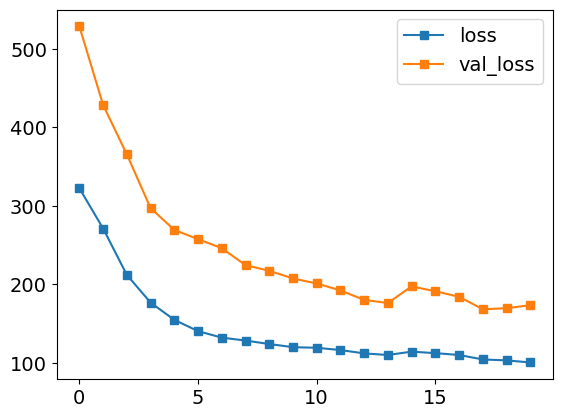

In [17]:
for name, values in history.items():
    plt.plot(values, 's-', label=name)
plt.legend(fontsize=14)
plt.show()

In [18]:
rmse = model.evaluate(test_ds)**0.5
print(f"Test RMSE: {rmse:.2f} nano-Tesla")

558/558 [==============================] - 39s 69ms/step - loss: 163.6485
Test RMSE: 12.79 nano-Tesla


### Model Performance Evaluation

Here you'll get experience with:
* Introductory explainable AI (XAI) via Permutation Importance
* Model performance on user chosen storm events

#### Permutation Importance - Easy Approximation

<div class="alert alert-block alert-info">
<b>Info:</b> Based on Christoph Molnar's "Interpretable Machine Learning" section and Fisher, Rudin, and Dominici (2018), we will "split the dataset in half and swap the values of feature j of the two halves instead of permuting feature j".     
</div>

Additional Resources:
*   Christoph Molnar's "Interpretable Machine Learning" section on [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), and see also their <b>argument for using Test data</b> for Permutation Importance evaluation, which we have chosen to do here.
*   [Illustrative graphic demonstrating single- and multi-pass Permutation Importance](https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance)
*   [Permutation Feature Importance in the <i>scikit-learn</i> module](https://scikit-learn.org/stable/modules/permutation_importance.html)


Basically, we can split and swap the feature datasets one feature at a time and compare the resultant RMSE. We take a programming convenience shortcut and <b>simply reverse each feature</b> vector rather than split and swap and we expect the same results. We'll do this, i.e. permute each feature vector, one at a time.

<div class="alert alert-block alert-info">
<b>Tip:</b> Recall that our <i>test_ds</i> which we used to evaluate the model performance is a <a href="https://www.tensorflow.org/guide/data#batching_dataset_elements">tensorflow.python.data.ops.dataset_ops.BatchDataset</a> and these are honestly kind of hard to work with. So we will recreate a deep copy of <b><i>test_ds</i></b> for each permutation and so we don't corrupt the original.
</div>

In [19]:
# Note: We shouldn't need these two lines below but they seem needed generalizing to run w/o
#       issues on both Colaboratory (Python 3.7) and Jupyter server with Python 3.9.
#       Contact POCs if you get an error such as:
#            AttributeError: module 'keras.preprocessing' has no attribute 'timeseries_dataset_from_array'
import tensorflow.keras as keras
from keras import preprocessing

In [20]:
# A couple of ways to learn about the contents of a BatchDataset:
#   print(list(test_ds.as_numpy_iterator()))
#   type(test_ds)


rmse_permute_df = pd.DataFrame(np.zeros((1,len(XCOLS))), columns=XCOLS)
for fname in XCOLS:

    # We're going to edit this data so make a deep copy of our preprocessed training dataset.
    test_for_permute = test.copy(deep=True)

    # Approximate split permutation by simply reversing the data in this feature
    test_for_permute[fname].values[:] = test_for_permute[fname].values[::-1]

    # create TensorFlow BatchDataset
    permute_ds = timeseries_dataset_from_df(test_for_permute, data_config["batch_size"])

    # evaluate model
    rmse_permute_df[fname] = model.evaluate(permute_ds)**0.5

    print('%s: %f rmse nano-Tesla' % (fname, rmse_permute_df[fname]))

558/558 [==============================] - 38s 68ms/step - loss: 190.4299
bt_mean: 13.799636 rmse nano-Tesla
558/558 [==============================] - 46s 82ms/step - loss: 161.5839
temperature_mean: 12.711564 rmse nano-Tesla
558/558 [==============================] - 36s 65ms/step - loss: 167.0069
bx_gsm_mean: 12.923114 rmse nano-Tesla
558/558 [==============================] - 41s 73ms/step - loss: 173.1632
by_gsm_mean: 13.159147 rmse nano-Tesla
558/558 [==============================] - 34s 60ms/step - loss: 334.1352
bz_gsm_mean: 18.279366 rmse nano-Tesla
558/558 [==============================] - 53s 96ms/step - loss: 216.5030
speed_mean: 14.714041 rmse nano-Tesla
558/558 [==============================] - 54s 97ms/step - loss: 169.8606
density_mean: 13.033059 rmse nano-Tesla
558/558 [==============================] - 56s 100ms/step - loss: 169.9884
bt_std: 13.037961 rmse nano-Tesla
558/558 [==============================] - 58s 103ms/step - loss: 164.2722
temperature_std: 12.8168

<div class="alert alert-block alert-info">
<b>Info:</b> Permutation Importance is evaluated as the influence a feature has relative to our unpermuted baseline performance. It's typical to use either a ratio or subtraction to relate to our baseline. Here we use a ratio.
</div>

In [21]:
# Ratio the Permuted RMSE to the overall RMSE and sort in order of importance
print('In order of most important feature first to least important by rmse(j)/rmse:')
rmse_ratio_df = (rmse_permute_df/rmse).sort_values(ascending=False, by=0, axis=1)
rmse_ratio_df.T

In order of most important feature first to least important by rmse(j)/rmse:


,0
bz_gsm_mean,1.428911
speed_mean,1.150207
bt_mean,1.078727
smoothed_ssn,1.035034
by_gsm_mean,1.028660
by_gsm_std,1.028464
bt_std,1.019187
density_mean,1.018803
bx_gsm_std,1.011768
bx_gsm_mean,1.010209


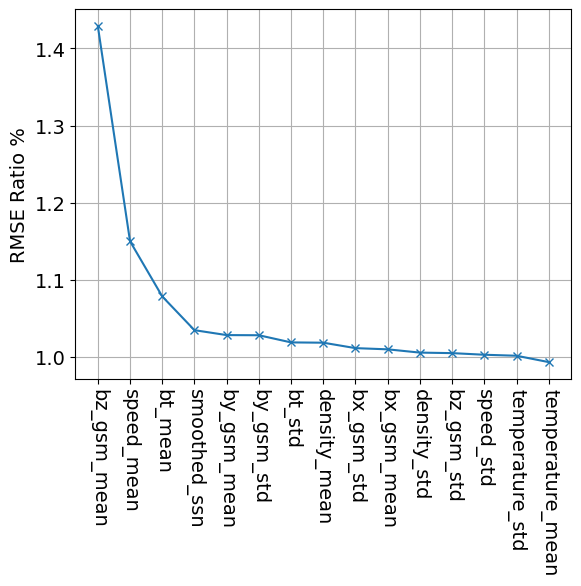

In [22]:
# Visualize the Permutation Importance outcome
plt.plot(rmse_ratio_df.columns, rmse_ratio_df.values.T, 'x-')
plt.xticks(rotation=270)
plt.ylabel('RMSE Ratio %')
plt.grid(True)
plt.show()

# Uncomment for a Pandas barplot:
# (Note that there might be too many colors to easily interpret)
#rmse_ratio_df.plot(kind='bar', figsize=(10, 5))
#plt.title('Permutation Feature Importance')
#plt.xlim(-0.25,)
#plt.ylim(0.95, rmse_ratio_df.iloc[0,0])
#plt.grid(True)
#plt.tight_layout()

#### Use these Feature Importances to Aid Evaluation

<div class="alert alert-block alert-success">
<b>Exercise:</b> What are the model sensitivities to the input parameters?

- How do our input data (features) compare in their influence on performance in predicting <i>Dst</i>?
    
- How does the order of this list compare to your intuition from the Feature Correlation Heatmap we made in the beginning of this notebook?
</div>

### Event Case Studies

To fully evaluate our model's performance, we need to get familiar with how well it generalizes to a diverse set of geomagnetic storm events including their preconditioning. Even though we split our data into 'Train', 'Validation', and 'Test' using best practices to avoid over/under fitting, looking at specific events while leveraging our space weather geomagnetic intuition will help us gain insight into how the model performs across different phases of different types of storms.

<div class="alert alert-block alert-info">
<b>Tip: </b>You can use these storm phase descriptions for contextualizing your experience:

* Climatology / quiet periods: Dst is generally horizontal and nearly 0 nano-Tesla.
* Sudden Impulse: Dst rises from near 0 to positive values rapidly over a few hours.
* Storm Sudden Commencement and Main Phase: Dst drops sharply and remains significantly negative for up to several days.
* Storm Peak: Dst reaches its minimum (most negative) value.
* Recovery Phase: Dst recovers from large negative values back to climatology, near 0 nano-Tesla.
</div>

#### Define Prediction Function

In [23]:
from typing import Tuple

TIMESTEPS = data_config['timesteps']

def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """Take all of the data up until time t-1, and then make predictions for times t and t+1.
    
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """

    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"].values[:] = latest_sunspot_number

    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    #pprint.pprint(features)

    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

#### Ingest Real Event Data from Competition's "Private" Data
Recall the data we call "private" here is now publicly accessible, since the MagNet competition has ended. It was the "private" data held back from the competitors for use by the evaluators to judge the competition entries.

In [24]:
# Real Event Data that was previously held back from the competitors
DATA_PATH = Path("data/private/")
print('Importing data from: %s' % DATA_PATH)

print('Reading in the Dst output data...')
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)

Importing data from: data/private
Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


#### Event: Geomagnetic storm with <i>Dst</i> minimum of approx. -180 nT

In [25]:
''' User Choice of Case Study Event '''
# Here we've chosen a specific event case study, you can choose different
#      case studied by looking at the sibling notebook magnet_cnn_tutorial.ipynb
#      TODO: for the correct sunspot value, currently, you have to manually peek
#            into the sunspots DataFrame and identify the closest match manually.
event_start_day = 140
latest_sunspot_number = sunspots.iloc[5]     # The nearest match for Day 140.
''' End User Config '''

# Setup our range indices
idx_event_1day = range(event_start_day,       event_start_day       + 7      )
idx_event_1hr  = range(event_start_day*24,    event_start_day*24    + 7*24   )
idx_event_1min = range(event_start_day*24*60, event_start_day*24*60 + 7*24*60)

dst_predicted_t0 = np.nan * np.zeros(len(idx_event_1hr))
dst_predicted_t1 = np.nan * np.zeros(len(idx_event_1hr))
i_dst = 0
###idx_1min = range((event_start_day-7)*24*60, event_start_day*24*60)
for i_offset_hour in range(-7*24, 0):

    # for the
    idx_7day_1min = range(idx_event_1min[0]+i_offset_hour*60 - 1,  idx_event_1min[-1]+i_offset_hour*60 - 1)

    idx_7day_1day = range(idx_event_1day[0]+i_offset_hour//24, idx_event_1day[-1]+i_offset_hour//24)

    # Subset to 7 days around event
    solar_wind_7d_by_min          = solar_wind.iloc[idx_7day_1min]
    satellite_positions_7d_by_day = satellite_positions.iloc[idx_7day_1day]

    # Predict Dst
    dst_t0_t1 = predict_dst(solar_wind_7d=solar_wind_7d_by_min, satellite_positions_7d=satellite_positions_7d_by_day, latest_sunspot_number=latest_sunspot_number)

    dst_predicted_t0[i_dst] = dst_t0_t1[0]
    dst_predicted_t1[i_dst] = dst_t0_t1[1]

    i_dst += 1

    # Uncomment to see the input and output data every hour:
    #print('Hour %4d: SSN %.1f, Bz %.1f nT, V %.0f km/s, Dst [t0,t1] = [%.1f, %.1f] nT'
    #    % (i_offset_hour, latest_sunspot_number, solar_wind_7d_by_min['bz_gsm'].mean(),
    #    solar_wind_7d_by_min['speed'].mean(), dst_t0_t1[0], dst_t0_t1[1]))


'''
# Summarize final block of Input data
print('\nSummarizing final block of input data (head and tail):')
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].head())
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].tail())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].head())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].tail())
pprint.pprint(latest_sunspot_number)
'''

"\n# Summarize final block of Input data\nprint('\nSummarizing final block of input data (head and tail):')\npprint.pprint(solar_wind_7d_by_min['bz_gsm'].head())\npprint.pprint(solar_wind_7d_by_min['bz_gsm'].tail())\npprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].head())\npprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].tail())\npprint.pprint(latest_sunspot_number)\n"

In [26]:
# RMSE for this event:
#      Remember to line the indices up for observed Dst and predicted Dst[t1]
rmse_t0 = np.mean((dst['dst'][idx_event_1hr]     - dst_predicted_t0     )**2)**0.5
rmse_t1 = np.mean((dst['dst'][idx_event_1hr][1:] - dst_predicted_t1[:-1])**2)**0.5
print('RMSE to t0 prediction: %f nT' % rmse_t0 )
print('RMSE to t1 prediction: %f nT' % rmse_t1 )

RMSE to t0 prediction: 43.441645 nT
RMSE to t1 prediction: 42.952979 nT


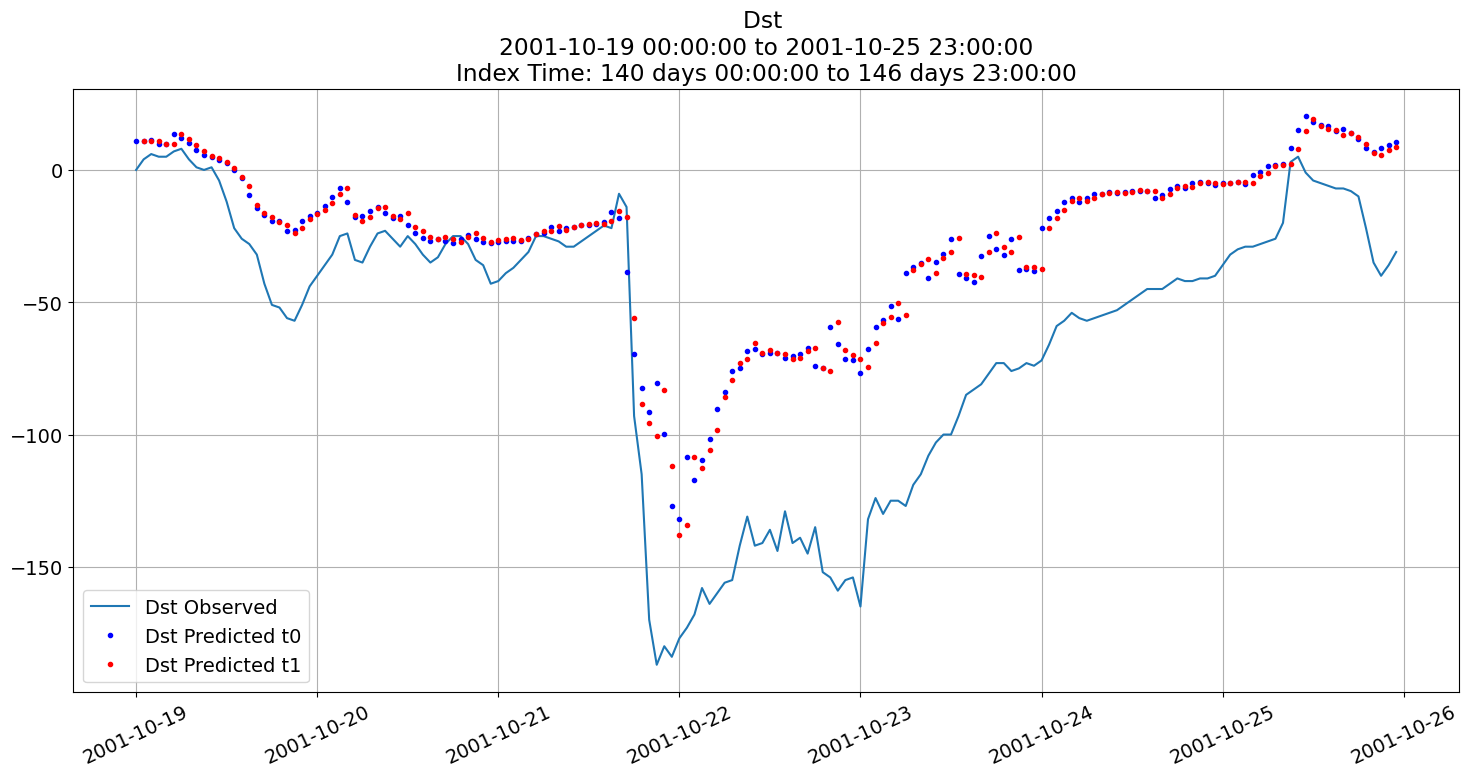

In [27]:
# Get real geophysical datetimes from our timedelta:
dst_datetime = convert_timedelta_to_datetime(dst)
x_values = dst_datetime['datetime'][idx_event_1hr].values

# Dst Observed
title = 'Dst \n%s to %s\nIndex Time: %s to %s' % \
    (dst_datetime['datetime'][idx_event_1hr][0],
    dst_datetime['datetime'][idx_event_1hr][-1],
    dst_datetime.index[idx_event_1hr[0]][1], dst_datetime.index[idx_event_1hr[-1]][1])

fig = plt.figure(figsize=(15,8))
plt.plot( x_values, dst['dst'][idx_event_1hr].values, label='Dst Observed')
plt.xticks(rotation=25)
plt.title( title )

# Dst Predicted at t0 and t1
#      Shift Dst[t1] to the right one hour to line up with the time axis
ax = plt.gca()
ax.plot(x_values, dst_predicted_t0, 'b.', label='Dst Predicted t0')
ax.plot(x_values, np.concatenate(([np.nan],dst_predicted_t1[:-1])), 'r.', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()

In [28]:
''' Uncomment this block if you want to plot just the Dst predictions.
# Dst Predicted
fig = plt.figure(figsize=(15, 8))

plt.plot(dst_predicted_t0, 'b', label='Dst Predicted t0')
plt.plot(dst_predicted_t1, 'r', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.title('Dst Predicted')

plt.tight_layout()
'''

" Uncomment this block if you want to plot just the Dst predictions.\n# Dst Predicted\nfig = plt.figure(figsize=(15, 8))\n\nplt.plot(dst_predicted_t0, 'b', label='Dst Predicted t0')\nplt.plot(dst_predicted_t1, 'r', label='Dst Predicted t1')\nplt.grid(True)\nplt.legend(fontsize=14)\nplt.title('Dst Predicted')\n\nplt.tight_layout()\n"

<div class="alert alert-block alert-success">
<b>Exercise:</b> Prediction Performance:

How does our LSTM model output for this event look compared to our observed <i>Dst</i>?
</div>

## Student Exercise: Additional Case Studies and Degraded Data

---

## Exercises

### Additional Excercises - Using the current notebook

The following exercises are designed to help expand your intuition, by extending concepts in earlier sections. You should find these straight forward to engage in, using the materials in this notebook plus a couple of supplementary resources as indicated below.

<div class="alert alert-block alert-success">
    <b>Exercise: </b> Together with the <b>Chapter 1</b> notebook you can adjust the list of inputs (features) used to train the model and compare the losses, as well as performance in predicting specific storms.
</div>

<div class="alert alert-block alert-success">
<b>Exercise: </b> Are there any additional inputs (features) we should consider adding to improve our prediction of <i>Dst</i>?
</div>

<div class="alert alert-block alert-success">
<b>Exercise:</b> Improving Performance: 
    
What hyper parameter changes to the LSTM architecture might you explore to increase its performance?
</div>

<div class="alert alert-block alert-info">
<b>Hint:</b> You can use the model loading section of this notebook to load a different pre-trained LSTM model. Or you can use the model definition section of the <b>Chapter 1</b> notebook to adjust the hyper parameters and train a new model.
</div>

<div class="alert alert-block alert-success">
<b>Exercise:</b> Instrument Availability:

If one or more solar wind instruments were to degrade on orbit how might this impact model performance?
</div>

<div class="alert alert-block alert-info">
<b>Hint:</b> Review the model sensitivities to the input parameters via the permutation importance section.
</div>

<div class="alert alert-block alert-success">
<b>Exercise: </b>LSTM versus CNN:

- For the baseline storm event above, how does our LSTM model performance compare to the <a href="https://github.com/ai2es/tai4es-trustathon-2022/tree/main/space">TAI4ES CNN notebook</a>?
- Compare and contrast the influence of features on this notebook's LSTM model with those in the <a href="https://github.com/ai2es/tai4es-trustathon-2022/tree/main/space">TAI4ES CNN notebook</a>. 
- How might these differences speak to differences in the performance of the two models?
- Are there storm events where LSTM is close to performing as well as the CNN model?
- Are there phases or characteristics of different storm events where LSTM or CNN do better than each other?
</div>

<div class="alert alert-block alert-info">
<b>Tip: </b>You can use these storm phase descriptions for contextualizing your findings:

* Climatology / quiet periods: Dst is generally horizontal and nearly 0 nano-Tesla.
* Sudden Impulse: Dst rises from near 0 to positive values rapidly over a few hours.
* Storm Sudden Commencement and Main Phase: Dst drops sharply and remains significantly negative for up to several days.
* Storm Peak: Dst reaches its minimum (most negative) value.
* Recovery Phase: Dst recovers from large negative values back to climatology, near 0 nano-Tesla.

<div class="alert alert-block alert-success">
<b>Exercise: </b>Degraded Observations

Degrade the instrument measurements and run the model to see how the performance is impacted. Start simple by adding Gaussian noise (mean 0), to the least important and the most important input parameters (aka features) and evaluating a specific event.
</div>

---

## Next steps

Congragulations on engaging with the learning objectives of this <b>Chapter 2</b> LSTM focused notebook--the benchmark from the NOAA MagNet competition. There is one additional <b>Chapter 1</b> notebook in the MagNet LSTM series, on model development in case you didn't start there.

There is an additional NCAI notebook in preparation for this MagNet series:
A higher performing ensemble Convolutional Neural Netowork (CNN) from the NOAA Geomagnetism team based on the 2nd place entry from the MagNet competition. 
As mentioned in an earlier section, this notebook's precursor is the [TAI4ES Space Weather CNN Notebook](https://github.com/ai2es/tai4es-trustathon-2022/tree/main/space)

Additionally, a web search will provide other <i>Dst</i> modeling notebooks and publications using ML techniques.

---

## Examples in the community

For a comprehensive treatment of the need to build robust predictions of the <i>Dst</i> space weather storm indicator (e.g. for magnetic navigation applications), see Nair et al., 2023 and references therein:
* Nair et al., 2023 (<i>in press</i>) (TODO: Update with public URL as soon as available),

For a summary, see:
* https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/


---

## Data statement
The competition discussed above used <i>public</i> data for development and the public leaderboard. A <i>private</i> dataset was kept internal during the competition for use in scoring by the organizers. Since the competition has passed, both datasets are publicly accessible from NOAA.

All data used in this notebook are publicly available here:
* https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
* https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip

---

## References

* Nair, M., Redmon, R.J., Young, L.Y., Chulliat, A., Trotta, B., Chung, C., Lipstein, G., Slavitt, I. (2023),"MagNet - a data-science competition to predict Disturbance Storm-time index (Dst) from solar wind data", Space Weather, <i>In Press</i>.
* [CIRES GeoMag MagNet repository](https://github.com/liyo6397/MagNet/), TODO: update URL to new CIRES repo.
* [Trustworthy Artificial Intelligence for Environmental Science 2022 Summer School](https://www2.cisl.ucar.edu/events/tai4es-2022-summer-school), TAI4ES, accessed July 2022.
* [TAI4ES Space Weather Notebooks (LSTM, CNN)](https://github.com/ai2es/tai4es-trustathon-2022/tree/main/space), GitHub, accessed July 2022.
* [MagNet: Model the Geomagnetic Field](https://ngdc.noaa.gov/geomag/mag-net-challenge.html), NOAA, accessed March 2022.
* Chung, C. (2020), "HOW TO PREDICT DISTURBANCES IN THE GEOMAGENTIC FIELD WITH LSTMS - BENCHMARK", Blogpost, Accessed March 2022, Available Online: https://drivendata.co/blog/model-geomagnetic-field-benchmark/.
* DrivenData (2020), "MagNet: Model the Geomagnetic Field", Web Resource, Accessed March 2022, Available Online: https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/.
* [Interpretable Machine Learning by Christop Molnar](https://christophm.github.io/interpretable-ml-book/shap.html)
* Redmon, R. J., Seaton, D. B., Steenburgh, R., He, J., & Rodriguez, J. V. (2018). September 2017's geoeffective space weather and impacts to Caribbean radio communications during hurricane response. Space Weather, 16, 1190–1201. https://doi.org/10.1029/2018SW001897

---

## Metadata
 * Language / package(s):
     * Language: Python, 
     * Packages: Keras Tensor Flow, Matplotlib, Numpy, Pandas, Scikit-learn
 * Scientific domain:
     * Space Weather, Geomagnetic modeling
 * Application keywords
     * Magnetic Navigation
 * Geophysical keywords
     * Disturbance Storm Index (<i>Dst</i>), Solar Wind
 * AI keywords
     * Long Short-Term Memory (LSTM)
     * Explainable AI (XAI), Permutation Feature Importance

---

## License

### Software and Content Description License
Software code created by U.S. Government employees is not subject to copyright in the United States (17 U.S.C. §105). The United States/Department of Commerce reserve all rights to seek and obtain copyright protection in countries other than the United States for Software authored in its entirety by the Department of Commerce. To this end, the Department of Commerce hereby grants to Recipient a royalty-free, nonexclusive license to use, copy, and create derivative works of the Software outside of the United States.

---

## Disclaimer

> This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.